## Dimensionality reduction and reconstruction : Autoencoders & PCA 

In this notebook, we are going to build and train an autoencoder on a dataset of digit images (MNIST).

In [2]:
# tested with pytorch 1.2.0 

# import matplotlib
# matplotlib.use('Qt4Agg') # if problem with PyQt5
import os
import matplotlib.pyplot as plt

my_seed = 0
import numpy as np
np.random.seed(my_seed)
import torch
torch.manual_seed(my_seed)
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from utils import to_img, plot_reconstructions_AE, plot_reconstructions_PCA, display_digits

%matplotlib inline

c:\Users\user\Anaconda3\envs\newenv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())
device = 'cpu'

Using gpu: False 


## Loading MNIST

In [4]:
if not os.path.exists('data'):
    os.makedirs('data')

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=1)

test_dataset = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=1)

Image dimension:(1, 28, 28)
Image values between 0.0 and 1.0
Label: 5


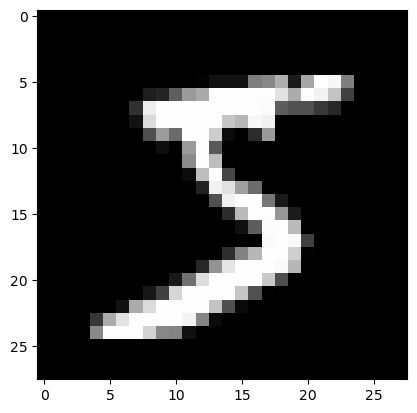

In [5]:
# get the first item in the training set and show properties

(img, label) = train_dataset.__getitem__(0) # this is a tuple (tensor, label)
print('Image dimension:%s'% (img.numpy().shape,)) # the first dimension is the channel, a color image could have 3 channels (R,G,B)
print('Image values between %.1f and %.1f' % (np.amin(img.numpy()), np.amax(img.numpy())))
print('Label: %d' % label)

plt.imshow(img[0,:].numpy(), cmap='gray')

## 1) Principal component analysis

Let's first see how principal component analysis (PCA) performs in dimensionality reduction and reconstruction. 

The projection matrix can be computed by diagonalization of the empirical covariance matrix of the data, or equivalently by singular value decomposition (SVD) of the data matrix. A quick google search outputs the following explanation about how to use SVD for PCA: https://stats.stackexchange.com/a/134283

In [6]:
class PCA():
    def __init__(self, encoding_dim):
        self.encoding_dim = encoding_dim
        
    def train(self, x):
        self.mu = x.mean(axis=0) # empirical mean
        U,s,V = np.linalg.svd(x - self.mu, full_matrices=False) # computes X = USV (and not USV^T)
        self.V = V.T # columns of V contain the eigenvectors of the empirical covariance matrix of x
        
    def encode(self, x):
        return (x - self.mu) @ self.V[:,:self.encoding_dim]
    
    def decode(self, z):
        return z @ self.V[:,:self.encoding_dim].T + self.mu
    
    def forward(self, x):
        z = self.encode(x)
        x = self.decode(z)
        return x

In [7]:
# get the data from the dataset

x_train = train_dataset.data.numpy().reshape(len(train_dataset), 784)/255 
y_train = train_dataset.targets.numpy()
x_test = test_dataset.data.numpy().reshape(len(test_dataset), 784)/255
y_test = test_dataset.targets.numpy()

In [8]:
# train the model

encoding_dim = 32 # latent space dimension (try with increasing values to see the results)

pca = PCA(encoding_dim)

pca.train(x_train)

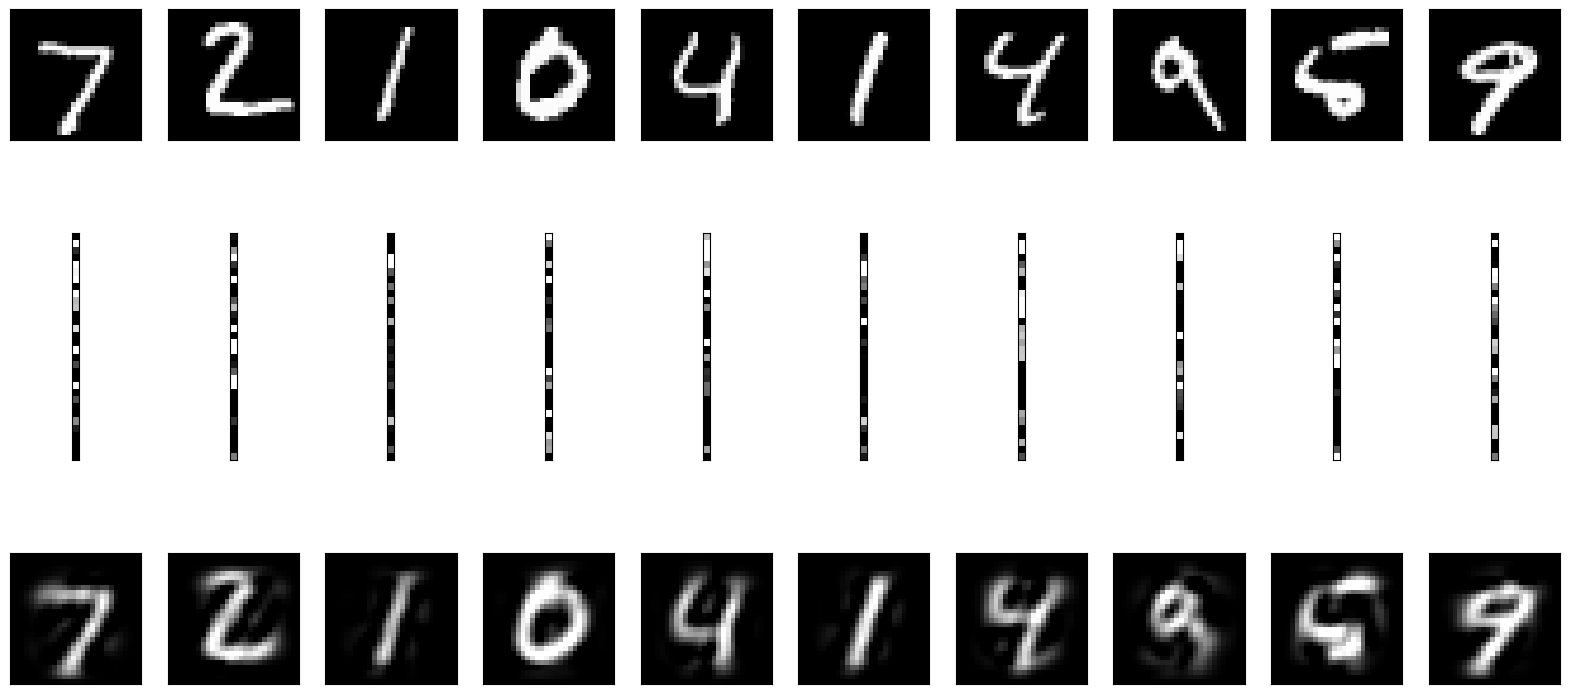

In [9]:
# plot reconstruction

plot_reconstructions_PCA(pca, test_loader)

In [10]:
# visualize the latent space

if encoding_dim == 2:
    z_test = pca.encode(x_test)
    cmap = plt.get_cmap('viridis', 10)
    plt.figure(figsize=[7,7])
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap=cmap, 
                 vmin=-0.5, vmax=9.5, marker='x', s=0.8)
    plt.colorbar()
    plt.title('PCA 2D latent space')

## 2) Autoencoder

#### a) We define the model

As MNIST image pixels lie between 0 and 1, we use a sigmoid activation function for the output layer of the decoder.

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        
        super(Autoencoder, self).__init__()
        
        self.encoder_fc1 = nn.Linear(input_dim, 512)
        self.encoder_fc2 = nn.Linear(512, 128)
        self.encoder_output = nn.Linear(128, encoding_dim)
        
        self.decoder_fc1 = nn.Linear(encoding_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 512)
        self.decoder_output = nn.Linear(512, input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def encode(self, x):
        """
        From a data vector (MNIST image), this function 
        computes and returns the latent vector (encoding step).
        """
    
        x = self.relu(self.encoder_fc1(x))
        x = self.relu(self.encoder_fc2(x))
        return self.encoder_output(x)
        
    
    def decode(self, z):
        """
        From a latent vector, this function computes and 
        returns the reconstructed data vector (MNIST image) 
        (decoding step).
        """
        
        z = self.relu(self.decoder_fc1(z))
        z = self.relu(self.decoder_fc2(z))
        return self.sigmoid(self.decoder_output(z))
        
    
    def forward(self, x):
        """
        From a data vector (MNIST image), this function computes and 
        returns its reconstruction after encoding and decoding.
        """
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

We instantiate the model:

In [12]:
encoding_dim = 32  # try with 2 than 32 to see the improvement

input_dim = 784 # images of 28 x 28 pixels

ae = Autoencoder(input_dim, encoding_dim)

ae = ae.to(device)

print(ae)

Autoencoder(
  (encoder_fc1): Linear(in_features=784, out_features=512, bias=True)
  (encoder_fc2): Linear(in_features=512, out_features=128, bias=True)
  (encoder_output): Linear(in_features=128, out_features=32, bias=True)
  (decoder_fc1): Linear(in_features=32, out_features=128, bias=True)
  (decoder_fc2): Linear(in_features=128, out_features=512, bias=True)
  (decoder_output): Linear(in_features=512, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


### Training the model

In the following cell, we apply the usual recipe to train a PyTorch model. We are here using **batch gradient descent**: we average the gradient over mini-batches of data before updating the network parameters.

We could use ```torch.nn.MSELoss``` but instead we "manually" define the loss.

In [13]:
n_epochs = 20 # number of epochs
n_training_samples = len(train_loader) # number of training samples
learning_rate = 1e-3 # learning rate
train_loss = [] # to store the training loss after each epoch

# we use Adam, a more sophisticated version of gradient descent
optimizer = optim.Adam(ae.parameters(), lr=learning_rate)

ae.train()

# Main training loop
for epoch in np.arange(n_epochs):
    
    train_acc_loss = 0 # the accumulated (summed) loss over the training batches
    
    print('Epoch: {}'.format(epoch+1))

    # Loop over the batches in the training set
    # note that 'train_loader' provides data 'x' and labels 'y', but we do not care about labels here
    for batch_idx, (x, y) in enumerate(train_loader): 

        x = x.view([-1, 784]).to(device) # reshape the 28x28 images
        batch_size = x.shape[0]
        
        ae.zero_grad() # reset the gradients
        
        x_hat = ae(x) # do the forward
        
        loss = torch.sum( (x_hat - x)**2 ) / batch_size  # compute the loss
        
        loss.backward() # do the backward
        
        optimizer.step() # do the minibatch gradient descent step (i.e. tune the network parameters)
        
        train_acc_loss += loss.item() # accumulate the loss over the training examples
        
        if (batch_idx+1) % 100 == 0:
            print('...Loss: {:.6f}'.format(loss.item()))
    
    # store the averaged training loss after each epoch
    train_loss.append(train_acc_loss) 

Epoch: 1
...Loss: 48.634323
...Loss: 33.426811
...Loss: 28.168606
...Loss: 24.525978
Epoch: 2
...Loss: 22.569918
...Loss: 16.345415
...Loss: 18.251236
...Loss: 15.684589
Epoch: 3
...Loss: 15.970942
...Loss: 11.836678
...Loss: 14.014814
...Loss: 11.698006
Epoch: 4
...Loss: 12.474335
...Loss: 9.478201
...Loss: 11.524310
...Loss: 9.632136
Epoch: 5
...Loss: 10.348888
...Loss: 7.967229
...Loss: 10.009005
...Loss: 8.290354
Epoch: 6
...Loss: 9.018670
...Loss: 7.060784
...Loss: 8.993906
...Loss: 7.475557
Epoch: 7
...Loss: 8.143095
...Loss: 6.430787
...Loss: 8.179632
...Loss: 6.832956
Epoch: 8
...Loss: 7.530459
...Loss: 5.910023
...Loss: 7.555236
...Loss: 6.314813
Epoch: 9
...Loss: 6.962396
...Loss: 5.560383
...Loss: 7.086387
...Loss: 5.904271
Epoch: 10
...Loss: 6.480359
...Loss: 5.298723
...Loss: 6.720796
...Loss: 5.604492
Epoch: 11
...Loss: 6.188535
...Loss: 5.053165
...Loss: 6.455616
...Loss: 5.339965
Epoch: 12
...Loss: 5.952934
...Loss: 4.843719
...Loss: 6.216568
...Loss: 5.103682
Epoch: 13

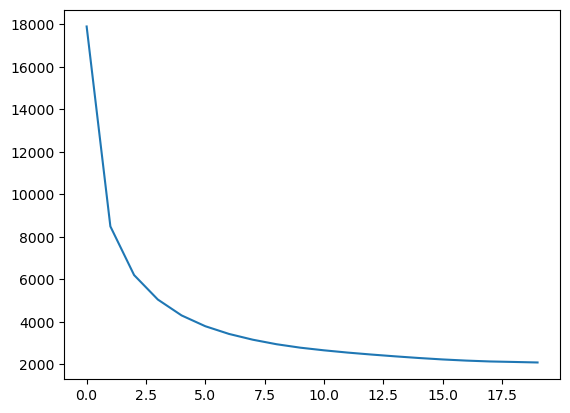

In [14]:
plt.plot(train_loss)

### Testing the model

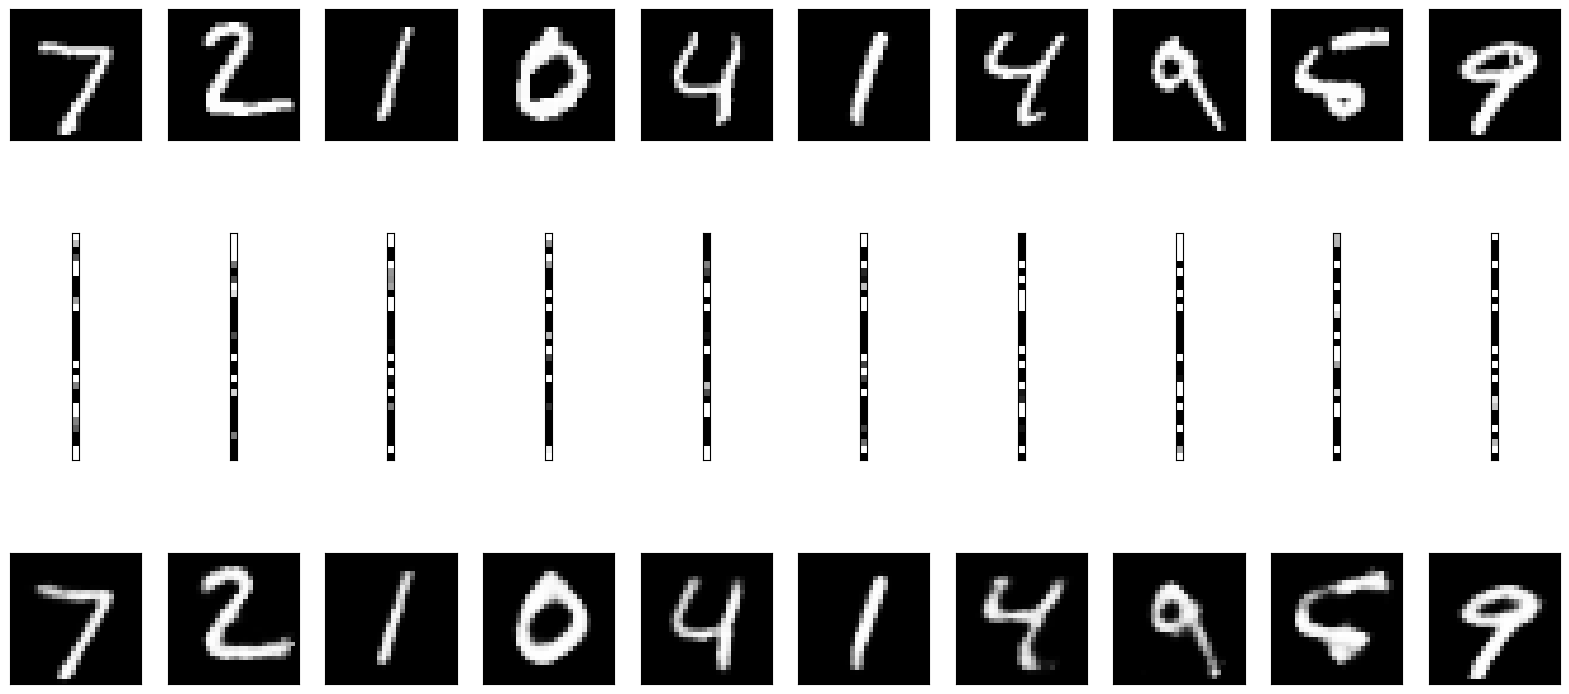

In [15]:
# plot reconstruction

from utils import plot_reconstructions_AE

plot_reconstructions_AE(ae, test_loader, device)

In [16]:
# visualize the latent space

if encoding_dim==2:

    z_test = np.zeros((len(test_dataset), encoding_dim))

    test_loader_batch_1 = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader_batch_1): 
            x = x.view([-1, 784]).to(device) # reshape the 28x28 images
            z_test[batch_idx,:] = ae.encode(x).cpu().numpy()
            
    
    # Use a discrete colormap
    cmap = plt.get_cmap('viridis', 10)
    plt.figure(figsize=[13,13])
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap=cmap, 
                 vmin=-0.5, vmax=9.5, marker='x', s=0.8)
    plt.colorbar()
    plt.title('Autoencoder 2D latent space')


To see a representation of the 2D latent space retrain with ```encod_dim = 2```

## 3) Interpolation in the latent space

We want to interpolate between the starting and ending images below.

Text(0.5, 1.0, 'ending image')

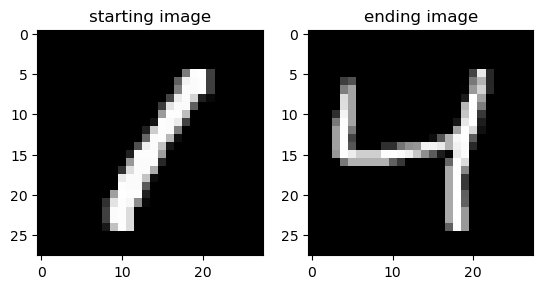

In [17]:
id_1 = 3
(x_1, label_1) = train_dataset.__getitem__(id_1) # this is a tuple (tensor, label)
# plt.imshow(x_1.numpy()[0,:], cmap='gray')

id_2 = 2
(x_2, label_2) = train_dataset.__getitem__(id_2) # this is a tuple (tensor, label)

plt.subplot(1,2,1)
plt.imshow(x_1.numpy()[0,:], cmap='gray')
plt.title('starting image')
plt.subplot(1,2,2)
plt.imshow(x_2.numpy()[0,:], cmap='gray')
plt.title('ending image')

In the following cell,we build the array ```x_interp``` of shape (1, 10, 28, 28) which contains 10 interpolations between the two images. 

In [18]:
x_interp = np.zeros((1, 10, 28, 28))

# encode the two images
z_1 = ae.encode(x_1.view([-1, 784]).to(device))
z_2 = ae.encode(x_2.view([-1, 784]).to(device))

alpha_vec = np.linspace(0,1,10)

#interpolate in the latent space and decode
for i, alpha in enumerate(alpha_vec):
    z = (1-alpha)*z_1 + alpha*z_2
    x_hat = ae.decode(z)
    x_interp[0,i,:,:] = to_img(x_hat)

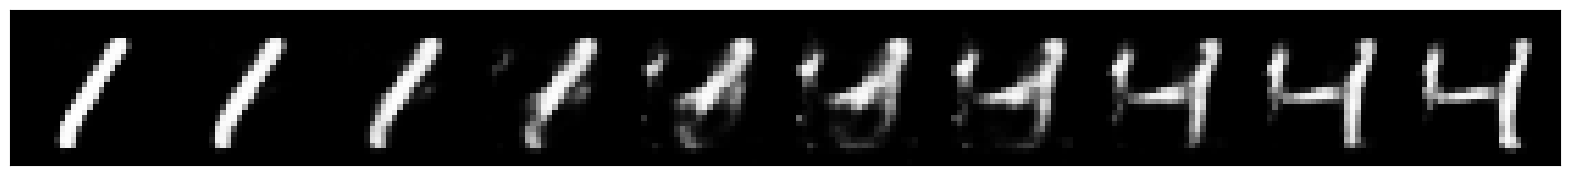

In [19]:
display_digits(x_interp)

## 3) Adapting the encoder for multiclass classification

Now that we trained our autoencoder on reconstructing the images, we want to see if we can get good results using the encoder part as a backbone for a classification model. We expect our encoder to have relevant features.

In [44]:
# we extract the encoder part 

encoder = nn.Sequential(
    ae.encoder_fc1,
    nn.ReLU(),
    ae.encoder_fc2,
    nn.ReLU(),
    ae.encoder_output
)

In [47]:
class MultiClassifier(nn.Module):
    
    def __init__(self, encoder, freeze_encoder = True):
        super(MultiClassifier, self).__init__()

        self.encoder = encoder
        self.num_features =  list(encoder)[-1].out_features
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
                
        self.fc = nn.Linear(in_features=self.num_features, out_features=10) # because there is 10 classes

    def forward(self,x):
        
        x = self.encoder(x)
        # x = torch.flatten(x, start_dim=1)
        x=self.fc(x)

        return x

In [58]:
model = MultiClassifier(encoder=encoder)

# Loss function for multi-class classification
multiclass_loss = nn.CrossEntropyLoss()

# Number of epochs
n_epochs = 30  # number of epochs
learning_rate = 5e-4 # learning rate

# Store training loss and accuracy
train_loss = []  # to store the training loss after each epoch
train_acc = []  # to store the training accuracy after each epoch

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()

# Main training loop
for epoch in np.arange(n_epochs):
    
    train_acc_loss = 0  # Accumulated (summed) loss over the training batches
    correct_predictions = 0  # Accumulate correct predictions
    total_samples = 0  # Count total samples

    # print('Epoch: {}'.format(epoch + 1))

    # Loop over the batches in the training set
    for batch_idx, (x, y) in enumerate(train_loader): 

        x = x.view([-1, 784]).to(device)  # Reshape the 28x28 images
        y = y.to(device)  # Move labels to the same device as the model
        batch_size = x.shape[0]
        
        model.zero_grad()  # Reset the gradients
        
        outputs = model(x)  # Forward pass
        
        loss = multiclass_loss(outputs, y)  # Compute the loss
        
        loss.backward()  # Backward pass
        
        optimizer.step()  # Update the weights
        
        train_acc_loss += loss.item()  # Accumulate the loss
        
        # Calculate accuracy for this batch
        predicted_labels = torch.argmax(outputs, dim=1)  # Get predicted labels
        correct_predictions += (predicted_labels == y).sum().item()  # Count correct predictions
        total_samples += batch_size  # Count total samples
        
        # if (batch_idx + 1) % 100 == 0:
        #     print('...Batch Loss: {:.6f}'.format(loss.item()))
    
    # Calculate and store averaged training loss and accuracy
    avg_loss = train_acc_loss / len(train_loader)
    avg_accuracy = correct_predictions / total_samples

    train_loss.append(avg_loss)
    train_acc.append(avg_accuracy)

    print('Epoch {} - Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, avg_loss, avg_accuracy))

Epoch 1 - Loss: 1.6229, Accuracy: 0.5025
Epoch 2 - Loss: 0.6220, Accuracy: 0.8384
Epoch 3 - Loss: 0.4654, Accuracy: 0.8746
Epoch 4 - Loss: 0.4036, Accuracy: 0.8872
Epoch 5 - Loss: 0.3709, Accuracy: 0.8937
Epoch 6 - Loss: 0.3513, Accuracy: 0.8978
Epoch 7 - Loss: 0.3384, Accuracy: 0.9005
Epoch 8 - Loss: 0.3297, Accuracy: 0.9025
Epoch 9 - Loss: 0.3234, Accuracy: 0.9039
Epoch 10 - Loss: 0.3189, Accuracy: 0.9049
Epoch 11 - Loss: 0.3155, Accuracy: 0.9055
Epoch 12 - Loss: 0.3129, Accuracy: 0.9060
Epoch 13 - Loss: 0.3109, Accuracy: 0.9064
Epoch 14 - Loss: 0.3093, Accuracy: 0.9067
Epoch 15 - Loss: 0.3081, Accuracy: 0.9070
Epoch 16 - Loss: 0.3071, Accuracy: 0.9073
Epoch 17 - Loss: 0.3062, Accuracy: 0.9074
Epoch 18 - Loss: 0.3055, Accuracy: 0.9076
Epoch 19 - Loss: 0.3049, Accuracy: 0.9079
Epoch 20 - Loss: 0.3044, Accuracy: 0.9081
Epoch 21 - Loss: 0.3039, Accuracy: 0.9082
Epoch 22 - Loss: 0.3035, Accuracy: 0.9084
Epoch 23 - Loss: 0.3032, Accuracy: 0.9085
Epoch 24 - Loss: 0.3029, Accuracy: 0.9087
E

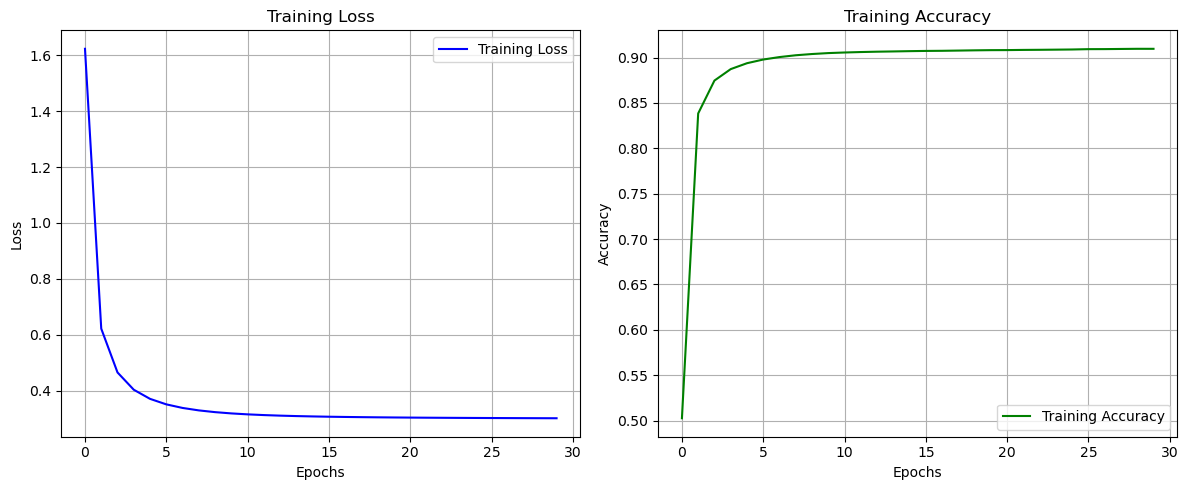

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Tracer la courbe de loss dans le premier sous-graphe
axes[0].plot(train_loss, label='Training Loss', color='blue')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# Tracer la courbe d'accuracy dans le second sous-graphe
axes[1].plot(train_acc, label='Training Accuracy', color='green')
axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()